### Avance 3
#### Baseline

Estudiantes:

- Carlos Alberto Reynoso Gonzalez | A01793188
- Israel Campos Báez | A01334976

Durante esta estapa se contestaron las siguientes preguntas

- <b>¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo? </b>

Dado que la base de datos esta compuesta por un matrices como variable de entrada que represanted la distribucion de inclusion en una pieza metalica, dicha matrices tiene solo un canal y su dominio es [0,1] en valores discretos, es decir, estamos hablando de una mascara. Esto significa que definitivamente un modelo con capa convolutivas es necesario.
De manera similar como variable de salida a predicir se tiene tambien una matriz de las mismas dimensiones y tambien solo un canal. En esta caso, la matriz representa los valores de estrés que el material sufre en cada uno de los elementos de la malla. Su dominio va de 0 a 300, que es al valor de esfuerzo en MPa (megapascales).
Dicho lo anterior, parece ser que tenemos un escenario de imagen-a-imagen (img2img).
El primer modelo que exploraremos para esta objetivo sera la *U-net* debido a su simplicidad.

- <b>¿Se puede determinar la importancia de las características para el modelo generado? Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales. </b>

Dada la sencilles de los datos de entrada, no se tiene mas variables que puedan incluir ruido en los resultados. Esto porque estamos trabajando con datos sinteticos.

#### Desarrollo

Antes de construir el modelo, se contruyen las funciones necesarias para importar los datos que fueron producidos por el simulador ANSYS.
Esto implica importar archivos de extension .txt que contienen los valores de estres del material resultantes de la simulacion. Estos valores estan en formatos de filas, cada fila contiene el valor y sus coordenadas x,y para indicar su posiscion en la malla del material.
En las funciones de abajo estos datos son recontruidos para representar los valores en un campo visual de 2 dimensiones.

In [ ]:

from scipy.interpolate import griddata
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from skimage.morphology import skeletonize
from torchvision import transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch.utils.data import random_split
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch.nn.functional as F

In [ ]:


def read(filename):
    """
    Reads a text file with node coordinates and stress values, scales the coordinates to integers,
    creates a 2D NumPy array with stress values at their respective (X, Y) positions,
    and fills gaps using interpolation.

    Parameters:
        filename (str): Path to the input text file.

    Returns:
        np.ndarray: 2D array with gaps filled by interpolation.
    """
    x_list, y_list, stresses = [], [], []

    with open(filename, 'r') as f:
        next(f)  # Skip header
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 5:
                continue
            # Extract and clean X, Y values (handle trailing dots)
            x = float(parts[1].rstrip('.'))
            y = float(parts[2].rstrip('.'))
            stress = float(parts[4])
            x_list.append(x)
            y_list.append(y)
            stresses.append(stress)


    scaling = 4

    # Scale coordinates to integers
    scaled_x = [int(round(x * scaling)) for x in x_list]
    scaled_y = [int(round(y * scaling)) for y in y_list]

    # Create mappings from unique scaled coordinates to indices
    unique_x = sorted(set(scaled_x))
    unique_y = sorted(set(scaled_y))
    x_to_idx = {x: idx for idx, x in enumerate(unique_x)}
    y_to_idx = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize matrix with NaNs
    matrix = np.full((len(unique_y), len(unique_x)), np.nan)

    # Populate the matrix with stress values
    for x, y, stress in zip(scaled_x, scaled_y, stresses):
        xi = x_to_idx[x]
        yi = y_to_idx[y]
        if matrix[yi, xi] is np.nan:
            matrix[yi, xi] = stress
        else:
            matrix[yi, xi]= (matrix[yi, xi] + stress) / 2

    # Prepare grid coordinates for interpolation
    grid_x, grid_y = np.meshgrid(unique_x, unique_y)
    points = np.array([[x, y] for x, y in zip(scaled_x, scaled_y)])
    values = np.array(stresses)

    # Interpolate missing values
    filled_matrix = griddata(points, values, (grid_x, grid_y), method='linear')
    flipped_matrix = filled_matrix[::-1, :].copy()


    return flipped_matrix

# Example usage:
# filled_matrix = read_and_create_matrix_with_interpolation('data.txt')
# print(filled_matrix)


In [ ]:


class StressDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        """
        Args:
            root_folder (str): Path to the root folder containing subfolders named from 1 to X.
            transform (callable, optional): Optional transform to apply to the images.
        """
        self.root_folder = root_folder
        self.transform = transform

        # Collect folder paths and labels from each subfolder
        self.data = []
        for folder_name in sorted(os.listdir(root_folder), key=lambda x: int(x)):
            folder_path = os.path.join(root_folder, folder_name)
            if os.path.isdir(folder_path):
                # Image and text file in the subfolder
                image_path = os.path.join(folder_path, "image.png")
                label_path = os.path.join(folder_path, "data2.txt")

                # Ensure both files exist
                if os.path.exists(image_path) and os.path.exists(label_path):
                    # Use the provided `read` function to process the label
                    stress_array = read(label_path)
                    self.data.append((image_path, stress_array))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image path and stress grid
        image_path, stress_grid = self.data[idx]

        # Open the image
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        #skl = skeletonize(np.array(image)) #for later
        image=np.array(image)
        #image=image+skl


        #min max scaling for image
        image = (image - image.min()) / (image.max() - image.min())

        image = Image.fromarray(image)
        #convert stress grid np to pil obj
        stress_grid = Image.fromarray(stress_grid)



        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            stress_grid=self.transform(stress_grid)
        else:
            image = transforms.ToTensor()(image)  # Default transformation to tensor
            stress_grid=transforms.ToTensor()(stress_grid)


        return image, stress_grid


Una vez codificadas las funciones para importar, todo se integra con una clase de base de datos de pytorch y se importa en el ambiente.

In [ ]:


# Path to the root folder containing subfolders
root_folder = "db/random/"

# Define transformations (e.g., resize images, normalize them, etc.)
transform_pipeline = transforms.Compose([
    transforms.Resize((126, 126)),  # Resize to 128x128 pixels
    transforms.ToTensor()          # Convert to a PyTorch tensor
])

# Create an instance of the dataset
dataset = StressDataset(root_folder=root_folder, transform=transform_pipeline)



Para observar y confirmar la correcta importancion, visualizamos las matrices. A la izquierda esta la matriz de entrada y a la derecha la de salida que buscaremos predicr a traves del modelo

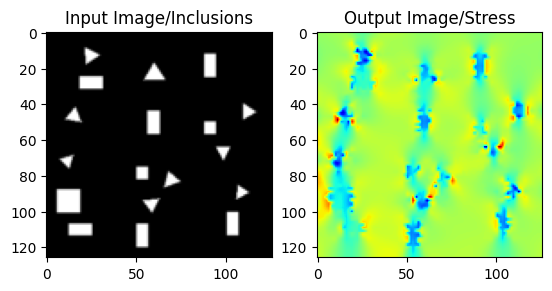

In [ ]:

i=26
in_=dataset[i][0][0,:,:]
out=dataset[i][1][0,:,:]
#plot 2x1 grid
fig, axs = plt.subplots(1, 2)
axs[0].imshow(in_, cmap='gray')
axs[0].set_title('Input Image/Inclusions')
axs[1].imshow(out, cmap='jet')
axs[1].set_title('Output Image/Stress')
plt.show()


Confirmada la importacion partimos la base de datos entre entrenamiento y validacion

In [ ]:


# Define the split ratio
val_ratio = 0.2  # 20% for validation
dataset_length = len(dataset)
val_len = int(val_ratio * dataset_length)
train_len = dataset_length - val_len

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

A continuación, se hace la implementación de la *U-net*. Convencionalmente, la *U-net* original tiene una función de actividad en su última capa, para que el resultado entre dentro de 0 y 1, dado su propósito de segmentar. Sin embargo; para nuestro proyecto, dicha activación fue removida porque el rango de la matriz de salida es de entre 0 y 300, es decir, estamos haciendo una regresión.

In [ ]:


class DoubleConv(nn.Module):
    """(Conv2D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad if necessary
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits  # No activation (raw output for regression)

Posteriormente, creamos la instancia, definimos la funcion de perdida y el optimizador.

In [ ]:
model = UNet()

In [ ]:
criterion = nn.MSELoss()  # Or SmoothL1Loss()


In [ ]:
optimizer = torch.optim.Adam(model.parameters())


Iniciamos el entrenamiento:


In [ ]:

train_losses = []
val_losses = []

train_loss = 0.0
val_loss = 0.0

# Initialize lists to store all predictions and truths for plotting
train_preds = []
train_truths = []
val_preds = []
val_truths = []



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 265
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for mask,output in train_loader:

        pred = model(mask)
        loss = criterion(output, pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    train_loss /= len(train_loader)
    train_losses.append(train_loss)


    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for mask,output in val_loader:

            pred = model(mask)
            val_loss += criterion(output, pred).item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

Epoch 1: Train Loss: 15573.3826 Val Loss: 15655.2183
Epoch 2: Train Loss: 15442.8955 Val Loss: 15559.0239
Epoch 3: Train Loss: 15377.7100 Val Loss: 15508.5874
Epoch 4: Train Loss: 15329.8252 Val Loss: 15478.8179
Epoch 5: Train Loss: 15283.7202 Val Loss: 15433.0142
Epoch 6: Train Loss: 15239.1011 Val Loss: 15400.4639
Epoch 7: Train Loss: 15195.6187 Val Loss: 15324.9604
Epoch 8: Train Loss: 15149.3459 Val Loss: 15108.3394
Epoch 9: Train Loss: 15102.3797 Val Loss: 15066.5210
Epoch 10: Train Loss: 15055.0220 Val Loss: 15008.5591
Epoch 11: Train Loss: 15005.8947 Val Loss: 15162.1211
Epoch 12: Train Loss: 14952.7733 Val Loss: 14834.3809
Epoch 13: Train Loss: 14902.3890 Val Loss: 14747.4307
Epoch 14: Train Loss: 14844.5062 Val Loss: 14591.2734
Epoch 15: Train Loss: 14790.0015 Val Loss: 14691.9170
Epoch 16: Train Loss: 14731.6986 Val Loss: 14620.3955
Epoch 17: Train Loss: 14674.2718 Val Loss: 14643.4292
Epoch 18: Train Loss: 14610.1156 Val Loss: 14538.0820
Epoch 19: Train Loss: 14546.7816 Val 

- <b>¿El modelo está sub/sobreajustando los datos de entrenamiento? </b>

Al final del entrenamiento,observamos una curva bastante limpia y predecible, esto se lo podemos atribuir a la naturaleza deterministica de los datos.
El error del dataset de validacion se mantiene cercano a de entrenamiento y en ningun momento divergen, por lo que descartamos cualquier sobre ajuste.

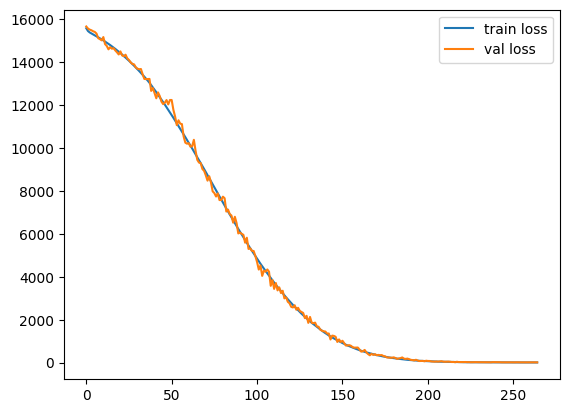

In [ ]:
#plot train and val losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

<b>-¿Cuál es la métrica adecuada para este problema de negocio? </b>

Puesto que estamos haciendo una regresión, proponemos las siguientes metricas
- MAE: Mean Ansolute Error
- RMSE: Root Mean Square Error
- R^2: Coeficiente de determinacion

In [ ]:


# Initialize metric storage
train_metrics = {"MAE": [], "RMSE": [], "R2": []}
val_metrics = {"MAE": [], "RMSE": [], "R2": []}


# Set model to evaluation mode
model.eval()

# Loop through the dataset
for i, (mask, output) in enumerate(val_dataset):
    mask = mask.unsqueeze(0)  # Add batch dimension
    output = output.unsqueeze(0)

    with torch.no_grad():  # Disable gradient tracking
        pred = model(mask)

    # Convert tensors to numpy
    mask_np = mask.cpu().numpy()
    output_np = output.cpu().numpy().flatten()
    pred_np = pred.cpu().numpy().flatten()


    # Compute metrics
    mae = mean_absolute_error(output_np, pred_np)
    mse = mean_squared_error(output_np, pred_np)  # Compute MSE first
    rmse = np.sqrt(mse)  # Manually calculate RMSE
    r2 = r2_score(output_np, pred_np)

    # Store metrics
    val_metrics["MAE"].append(mae)
    val_metrics["RMSE"].append(rmse)
    val_metrics["R2"].append(r2)

#average metrics
val_mae = np.mean(val_metrics["MAE"])
val_rmse = np.mean(val_metrics["RMSE"])
val_r2 = np.mean(val_metrics["R2"])

print(f"Validation MAE: {val_mae:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Validation R2: {val_r2:.2f}")



Validation MAE: 2.08
Validation RMSE: 3.53
Validation R2: 0.75


- MAE = 2.08 → En promedio, el modelo se equivoca por 2.08 unidades en sus predicciones.
- RMSE = 3.53 → El error típico es de 3.53 unidades, dando más peso a los errores grandes.
- R² = 0.75 → El modelo explica el 75% de la variabilidad en los datos reales.

In [ ]:
stress_actual=[]
stress_pred=[]

# Set model to evaluation mode
model.eval()

# Loop through the dataset
for i, (mask, output) in enumerate(val_dataset):
    mask = mask.unsqueeze(0)  # Add batch dimension
    output = output.unsqueeze(0)

    with torch.no_grad():  # Disable gradient tracking
        pred = model(mask)

    output_np = output.cpu().numpy()[0,0,:,:].flatten()
    pred_np = pred.cpu().numpy()[0,0,:,:].flatten()

    #convert np to list
    output_np=output_np.tolist()
    pred_np=pred_np.tolist()

    stress_actual.extend(output_np)
    stress_pred.extend(pred_np)



Adicionalmente, se grafica un dispersion de vaores predichos contra reales:

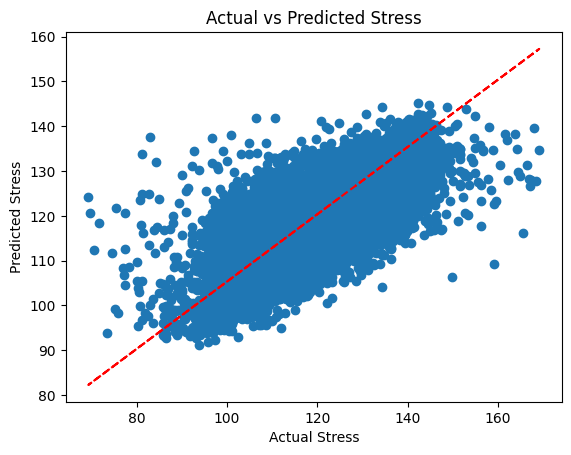

In [ ]:
#plot actual vs predicted stress

plt.scatter(stress_actual, stress_pred)
z = np.polyfit(stress_actual, stress_pred, 1)
p = np.poly1d(z)
plt.plot(stress_actual,p(stress_actual),"r--")
plt.xlabel('Actual Stress')
plt.ylabel('Predicted Stress')
plt.title('Actual vs Predicted Stress')
plt.show()


Finalmente, después de revisar las metricas anteriores, visualizamos las matrices de salida del modelo, las gráficas junto a la de las base de datos para comparar las diferencias.
Esto es para la base de datos de validación.

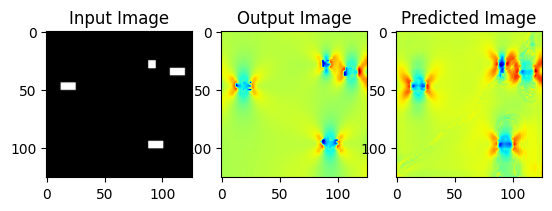

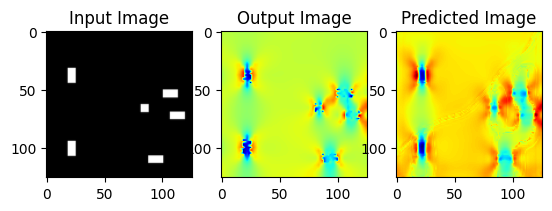

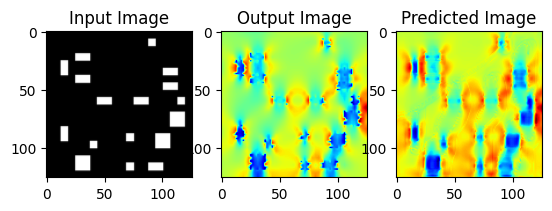

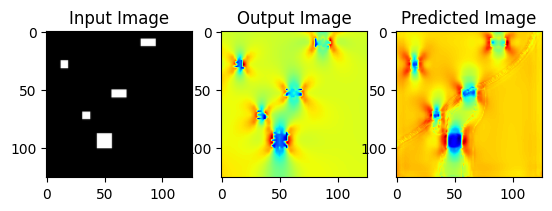

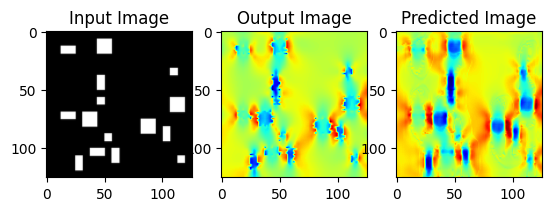

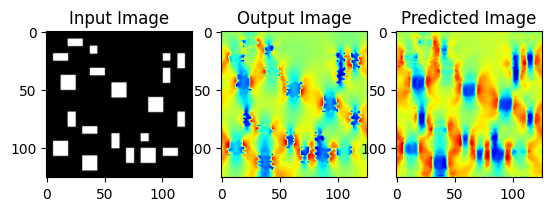

In [ ]:
#test the model on a single mask
model.eval()

for i in range(len(val_dataset)):

    mask=dataset[i][0].unsqueeze(0)
    output=dataset[i][1].unsqueeze(0)

    pred = model(mask)

    mask=mask.detach().numpy()
    output=output.detach().numpy()
    pred=pred.detach().numpy()


    #plot 3x1 grid
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(mask[0][0,:,:], cmap='gray')
    axs[0].set_title('Input Image')
    axs[1].imshow(output[0][0,:,:], cmap='jet')
    axs[1].set_title('Output Image')
    axs[2].imshow(pred[0][0,:,:], cmap='jet')
    axs[2].set_title('Predicted Image')
    plt.show()



### Conclusiones
Podemos confirmar que el modelo esta aprendiendo y reproduciendo los patrones de estrés de manera exitosa. Por ejemplo, es capaz de etender que el estrés siempre se acumular en los lados izquier y derecho de las inclusiones, y tambien en las esquinas.
También se aprecia que predice bien cuando hay inclusiones cercanas unas de otras, y el estrés se acumula en media de ellas.
Ha comprobado hacer una buena predicción con una base de datos limitada y a este punto ya funciona como una herramienta válida y rápida para observar la distribución de estrés en una pieza sujeta a presión.
Se considera que la estrategia de remover la funcion de activación de la *u-net* tuvo efectos positivos en el trabajo de regresión.
A pesar de los resultados alentadores, la precisión no es suficiente aún. En futuras pruebas se buscará que el modelo tenga al menos 85% en R^2.